In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from punisher.common import *
from punisher.utils.dates import utc_to_local

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download

In [3]:
# https://market.mashape.com/BraveNewCoin/digital-currency-ex-rates#mwa-historic-exchange-rates
# https://bravenewcoin.com/api/digital-currency-exchange-rates/

# Coins
# BTC start = 1396328100 - datetime.datetime(2014, 3, 31, 21, 55)
# ETH start = 1439011500 - datetime.datetime(2015, 8, 7, 22, 25)
# LTC start = 1396344000 - datetime.datetime(2014, 4, 1, 2, 20)
# XRP start = 1397010900 - datetime.datetime(2014, 4, 8, 19, 35)

# Meta
# columns = ['timestamp', 'index', 'volume', 'index_usd', 'volume_usd']
# Returns 1000 rows? Multiple days worth of data...
# 230 requests for 2 years of 5-min data?
# Looks like they fill in missing data with previous known price
# They have 0 volume days

In [112]:
asset = Asset(coins.BTC, coins.USD)
timeframe = Timeframe.FIVE_MIN
exchange_id = ex_cfg.BNC
start = datetime.datetime(year=2018, month=1, day=1, hour=0)
end = datetime.datetime(year=2018, month=1, day=2, hour=0)

In [138]:
df = ohlcv_feed.load_ohlcv(exchange_id, asset, timeframe)
df.head()

In [148]:
df = ohlcv_feed.load_multiple_assets(
    [ex_cfg.GDAX, ex_cfg.BNC], [asset], timeframe, start, end)
df.head()

,open_BTC/USD_gdax,high_BTC/USD_gdax,low_BTC/USD_gdax,close_BTC/USD_gdax,volume_BTC/USD_gdax,utc,open_BTC/USD_bnc,high_BTC/USD_bnc,low_BTC/USD_bnc,close_BTC/USD_bnc,volume_BTC/USD_bnc
epoch,,,,,,,,,,,
1514764800,13863.14,13885.34,13803.00,13803.00,18.827403,2018-01-01 00:00:00,13897.78968,13897.78968,13897.78968,13897.78968,1.309625e+09
1514765100,13803.00,13803.00,13676.41,13753.00,24.758469,2018-01-01 00:05:00,13849.65477,13849.65477,13849.65477,13849.65477,1.303419e+09
1514765400,13753.00,13753.00,13702.85,13718.14,18.308099,2018-01-01 00:10:00,13776.31215,13776.31215,13776.31215,13776.31215,1.297620e+09
1514765700,13718.13,13718.14,13650.00,13671.43,28.097246,2018-01-01 00:15:00,13748.76131,13748.76131,13748.76131,13748.76131,1.291662e+09
1514766000,13671.42,13683.62,13640.77,13662.80,18.360003,2018-01-01 00:20:00,13683.72755,13683.72755,13683.72755,13683.72755,1.279837e+09


In [149]:
df = df[[c for c in df.columns if 'close' in c or c in ['utc']]]
df.head()

,close_BTC/USD_gdax,utc,close_BTC/USD_bnc
epoch,,,
1514764800,13803.00,2018-01-01 00:00:00,13897.78968
1514765100,13753.00,2018-01-01 00:05:00,13849.65477
1514765400,13718.14,2018-01-01 00:10:00,13776.31215
1514765700,13671.43,2018-01-01 00:15:00,13748.76131
1514766000,13662.80,2018-01-01 00:20:00,13683.72755


## Plot

In [157]:
def plot_prices(time, close, title="Price"):
    fig, ax = plt.subplots()
    ax.plot(time, close)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    monthsFmt = mdates.DateFormatter('%m')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)

    # datemin = datetime.date(r.date.min().year, 1, 1)
    # datemax = datetime.date(r.date.max().year + 1, 1, 1)
    # ax.set_xlim(datemin, datemax)

    # # format the coords message box
    # def price(x):
    #     return '$%1.2f' % x
    # ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = price
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate(rotation=30)
    fig.set_size_inches(12,6)
    plt.title(title)
    #plt.show()

def plot_range(df, start, end, y_name):
    df = df[ (df['utc'] >= start) & (df['utc'] < end) ]
    vals = df[['utc', y_name]].values
    plot_prices(vals[:,0], vals[:,1], title=y_name)

In [158]:
df.columns

Index(['close_BTC/USD_gdax', 'utc', 'close_BTC/USD_bnc'], dtype='object')

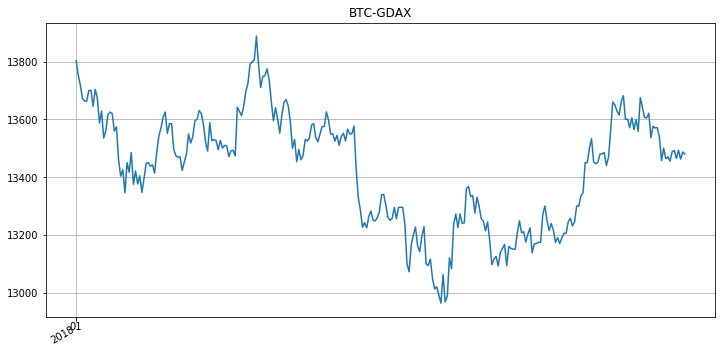

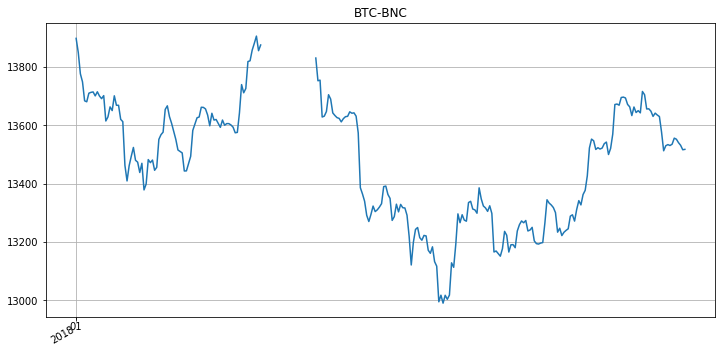

In [159]:
vals = df[['utc', 'close_BTC/USD_gdax']].values
plot_prices(vals[:,0], vals[:,1], 'BTC-GDAX')
vals = df[['utc','close_BTC/USD_bnc']].values
plot_prices(vals[:,0], vals[:,1], 'BTC-BNC')

### Bin

In [ ]:
def get_binned_prices(df, bin_size='30T'):
    # https://stackoverflow.com/questions/17001389/pandas-resample-documentation
    # http://benalexkeen.com/resampling-time-series-data-with-pandas/
    # price_df.resample(rule='30T').ohlc() - (open, high, low, close)
    
    df = df.set_index('utc')
    columns = df.columns
    binned = pd.DataFrame()
    for col in columns:
        if 'price' in col:
            binned['open_' + col] = df[col].resample(rule=bin_size).first().round(5)
            binned['close_' + col] = df[col].resample(rule=bin_size).last().round(5)
            binned['high_' + col] = df[col].resample(rule=bin_size).max().round(5)
            binned['low_' + col] = df[col].resample(rule=bin_size).min().round(5)
        elif 'volume' in col:
            binned[col] = df[col].resample(rule=bin_size).sum().round(0)
        else:
            binned[col] = df[col]
    binned['timestamp'] = [round(t.timestamp()) for t in binned.index]
    return binned

In [ ]:
currency_df = load_prices(coins=[coins.BTC, coins.ETH, coins.LTC], fiat=coins.USD, exchange=c.BNC, 
                       timestep_sec=300, loader=load_bnc_exchange_rate_data)

In [ ]:
currency_30min_df = get_binned_prices(currency_df, bin_size='30T')
currency_30min_df.head()

In [ ]:
qgrid_widget = qgrid.QgridWidget(df=currency_30min_df, show_toolbar=False)
qgrid_widget

## Analyze

In [ ]:
columns = [c for c in currency_30min_df.columns if 'close_price' in c]
price_df = currency_30min_df[columns]
price_df.columns = ['BTC', 'ETH', 'LTC']
price_df.head()

In [ ]:
# Normalize 
price_df_norm = price_df.divide(price_df.iloc[0])
price_df_norm.head()

In [ ]:
price_df_norm.plot()

In [ ]:
# Percent change (from ?)
# There are some outliers that will mess up a model. How to fix....
# for example, BTC on 2016-09-26 06:00:00
price_df_pct = price_df.pct_change()
price_df_pct = price_df_pct.replace([1.0, -1.0], np.nan)
price_df_pct = price_df_pct.replace([np.inf, -np.inf], np.nan)
price_df_pct = price_df_pct.dropna()
price_df_pct.head()

In [ ]:
# Correlation
# https://www.investopedia.com/terms/n/negative-correlation.asp
# https://medium.com/@eliquinox/cryptocurrency-data-analysis-part-ii-downloading-manipulating-and-analysing-bulk-data-e234a43e6259

corr = price_df_pct.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Print correlations
corr['BTC']['ETH'], corr['BTC']['LTC']

In [ ]:
plt.scatter(price_df_pct['BTC'], price_df_pct['LTC'])
plt.xlabel('BTC % Return')
plt.ylabel('LTC % Return')

In [ ]:
# Linear Regression
# https://www.datarobot.com/blog/ordinary-least-squares-in-python/
# http://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

import statsmodels.api as sm

# Dependent, Indenpendent
model = sm.OLS(price_df_pct['ETH'],
               price_df_pct['LTC']).fit()
model.summary()

# R squared - how much of LTC change can be explained by BTC changes?

In [ ]:
# multiply each value of BTC pct change by the slope coefficient
line = [model.params[0]*i for i in price_df_pct['BTC'].values]
plt.plot(price_df_pct['BTC'], line, c = 'r')
plt.scatter(price_df_pct['BTC'], price_df_pct['LTC'])
plt.xlabel('BTC % Return')
plt.ylabel('LTC % Return')

## Moving Average Crossover

In [ ]:
# https://en.wikipedia.org/wiki/Moving_average#Simple_moving_average
"""
Interestingly it looks like prices quoted in Bitcoin are more predictive ..
"""

coin = coins.LTC
fiat = coins.USD

df = load_prices(coins=[coin], fiat=fiat, exchange=c.BNC, 
                 timestep_sec=300, loader=load_bnc_exchange_rate_data)
df = df.set_index('utc')
df = df.rename(columns={'price_'+coin:'close'})
df = df.drop(['volume_'+coin], axis=1)

In [ ]:
df.head()

In [ ]:
# Add moving averages
df['SMA_1000'] = df['close'].rolling(1000).mean() # 16 hours
df['SMA_5000'] = df['close'].rolling(5000).mean() # 4 days
df[['close','SMA_1000','SMA_5000']][len(df)-15000:].plot(figsize = (16,10))
df = df.dropna()
df.head()

In [ ]:
"""
Strategy

BUY if Leading SMA is above Lagging SMA by some threshold.
SELL if Leading SMA is below Lagging SMA by some threshold.

Threshold = 2.5% of current price (filter out weak signals)
"""

def test_sma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()
    ma_df['lead'] = ma_df['close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['close'].rolling(lag).mean()
    ma_df.dropna(inplace = True)
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['close']
    ma_df['regime'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['regime'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['regime'])
    ma_df['Market'] = np.log(ma_df['close'] / ma_df['close'].shift(1))
    ma_df['Strategy'] = ma_df['regime'].shift(1) * ma_df['Market']
    ma_df[['Market','Strategy']] = ma_df[['Market','Strategy']].cumsum().apply(np.exp)
    return ma_df

In [ ]:
sma_df = test_sma(df, 100, 4100).dropna()
sma_df.head()

In [ ]:
sma_df['Strategy'][-1]

In [ ]:
# Buy / Short / Neutral Action
sma_df['regime'].plot(figsize=(16,5))

In [ ]:
# Compare to buy and hold
sma_df[['Market','Strategy']].iloc[-1]

In [ ]:
sma_df[['Market','Strategy']][len(sma_df)-100000:].plot(figsize = (16,10))

In [ ]:
# Search for Optimal Lead/Lag Periods
leads = np.arange(100, 4100, 100)
lags = np.arange(4100, 8100, 100)
lead_lags = [[lead, lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,  columns=leads)
print(len(lead_lags))

In [ ]:
for lead, lag in lead_lags:
    results = test_sma(df, lead, lag).dropna()
    pnls[lead][lag] = results['Strategy'][-1]
    print(lead, lag, pnls[lead][lag])

In [ ]:
pnls.head()

In [ ]:
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (14,10))
sns.heatmap(PNLs, cmap='PiYG')

In [ ]:
# Get max value for each lead lookback
"""
Lead of 900 periods produces maximum PnL. 
By referencing back the the matrix heatmap, we can find the corresponding lag period.

Optimal looks like (BTC):
    lead = 1200 - 1500
    lag = 5400 - 5800

lets say (1350, 5800)
ratio: 5:1
"""
PNLs.max()
print("optimal", PNLs[1300][5800])

## Assumptions

We ignore important factors:

* Commissions (25 bps)
* Shorting (usually can't do this)
* Slippage (we assume we will always get the order price we request)
* Market Impact (the market price may change when we start placing orders)
* Overfitting (We brute force searched for optimal lead/lag ratio - this won't generalize)
* Exchange risk (Exchanges get hacked)